In [16]:
# ----------------------------------------------------
# 
# lake driver script from Dee et al., modified by 
# Tyler Kukla for use without f2py and application
# to colorado plateau project of E Heitmann
# 
# ----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from math import pi, sqrt, exp
import subprocess  # for running fortran model
import pandas as pd
import os
import shutil

# sensor models
import sensor_gdgt as gdgt
import sensor_carbonate as carb


In [20]:
# --- [0] create case dir and move files
outdir = "/Users/tylerkukla/Documents/GitHub/PRYSM/psm/lake"
casename = "_test_case"
casedir = os.path.join(outdir, casename)
# create the new directory
os.makedirs(casedir, exist_ok=True)

# names of files to copy
files_to_copy = ['Tanganyika.inc', 'env_heatflux_locked.f90', 'CP_SLIM_lowTopo_500ppm_test_input.txt']

# copy each file into the new directory
for file in files_to_copy:
    fn = os.path.join(outdir, file)
    shutil.copy(fn, casedir)


In [21]:
# --- [1] Run the lake environment sub model
# 
# Note, this can take a while to run depending on the number of timesteps in the 
# lake model. The example run took my machine ~13 minutes
# 

os.chdir(casedir)

# Specify the fortran source file and the output binary
# 
# fortran_file = "env_sub.f90"    # name of the fortran file
fortran_file = "env_heatflux_locked.f90"
output_binary = "lakepsm"       # user-selected name of the compiled executable

# Construct the gfortran command
command = ["gfortran", fortran_file, "-o", output_binary]

# --- Compile
try:
    # Run the command
    result = subprocess.run(command, check=True, text=True, capture_output=True)
    print("Compilation successful!")
    # print("Output:", result.stdout)
except subprocess.CalledProcessError as e:
    print("Compilation failed!")
    print("Error output:", e.stderr)

# -----------------------------------

# --- Run (can take ~10-30 mins ish)
try:
    # Run the compiled program
    result = subprocess.run(["./" + output_binary], check=True, text=True, capture_output=True)
    print("Program output:")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Execution failed!")
    print("Error output:", e.stderr)

Compilation successful!
Program output:



In [3]:
# --- Pull data (lake surface temperature) from output from env
# model and use to run sensor model
surf_ouput = 'Tanganyika_IPSL_P3_MH_delta_prof.dat'
surf_tempr = []
with open(surf_ouput, 'r') as data:
	tempr_yr = [] 
	for line in data:
		line_vals = line.split()
		tempr_yr.append(line_vals[1])
	surf_tempr.append(tempr_yr[341:-11])
surf_tempr = np.array(surf_tempr[0], dtype = float) +275.15


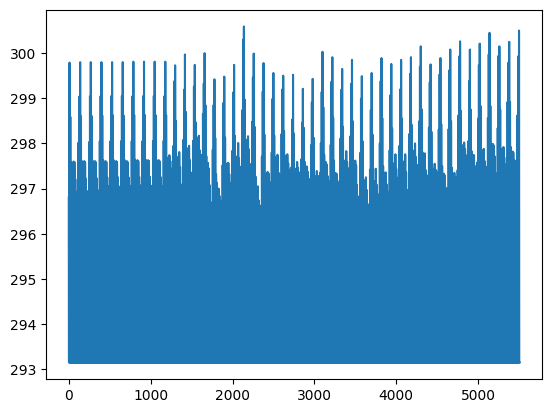

In [7]:
plt.plot(surf_tempr)

In [ ]:
# pd.read_csv(surf_output, delim_whitespace=True, header=None, skip_blank_lines=True)
surf_output = "lake_profile.txt"
with open(surf_output, 'r') as data:
    for line in data:
        line_vals = line.split()
		tempr_yr.append(line_vals[0])

      15.00       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99

      45.00       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99       22.99    

In [ ]:
# --- Pull data (lake surface temperature) from output from env
# model and use to run sensor model
surf_ouput = 'ERA-HIST-Tlake_surf.dat' # 'lake_profile.dat'
surf_tempr = []
with open(surf_ouput, 'r') as data:
	tempr_yr = [] 
	for line in data:
		line_vals = line.split()
		tempr_yr.append(line_vals[1])
	surf_tempr.append(tempr_yr[341:-11])
surf_tempr = np.array(surf_tempr[0], dtype = float) +275.15

climate_input = 'ERA_INTERIM_climatology_Tanganyika.txt'
air_tempr = []
with open(climate_input, 'r') as data:
    airtemp_yr = []
    for line in data:
        line_vals = line.split()
        airtemp_yr.append(line_vals[2])
    air_tempr.append(airtemp_yr[:-12])
air_tempr = np.array(air_tempr[0], dtype = float)


LST = surf_tempr  # THIS SHOULD BE THE FULL TIME SERIES of lake surface temp
MAAT = air_tempr  # Full timeseries of air temperatures
beta = 1./50.
d18Ow = -2 # To be set by the user if isoflag is off

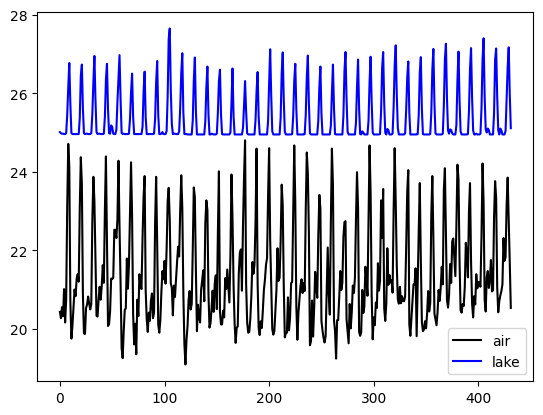

In [4]:
# --- quick plot of air versus lake temperatures
plt.plot(air_tempr - 273.15, c='black', label='air')
plt.plot(surf_tempr - 273.15, c='blue', label='lake')
plt.legend()

In [41]:
# 2.1 GDGT Sensors
gdgt_proxy = gdgt.gdgt_sensor(LST,MAAT,beta=beta,model = 'MBT')

# SAVE IN CURRENT DIRECTORY

np.save('gdgt_sensor.npy',gdgt_proxy)

# 2.2 Carbonate Sensor

carb_proxy = carb.carb_sensor(LST,d18Ow,isoflag=-1,model='ONeil')

# SAVE IN CURRENT DIRECTORY

np.save('carb_sensor.npy',carb_proxy)


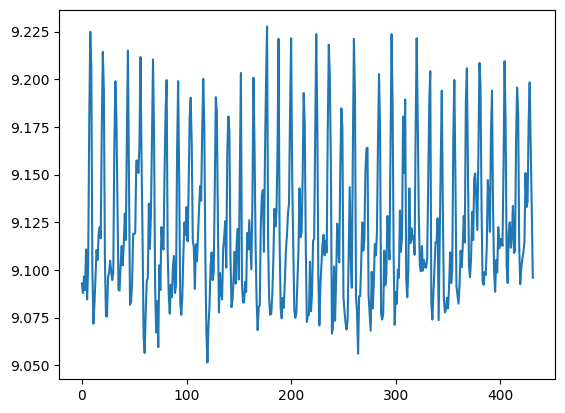

In [ ]:
# -- TK -- decide if we need compaction / bioturbation models

In [11]:
surf_ouput = 'lake_surface.dat'

In [12]:
# --- read in surface data
# define the column names
column_names = ["julianday", "LST_1m_degC", "E_lake_mmday", "mixdepth_mean_m", "d18Olake", 
                "dDlake", "a", "mixdepth_max_m", "lakedepth_m", "lakelevel_m_per_m"]
# (see more info on column names in table 1 here: https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018PA003413&file=palo20664-sup-0001-Supplementary.pdf)

# Read the .dat file into a pandas DataFrame
df = pd.read_csv(surf_ouput, delim_whitespace=True, header=None, names=column_names)

df


,julianday,LST_1m_degC,E_lake_mmday,mixdepth_mean_m,d18Olake,dDlake,a,mixdepth_max_m,lakedepth_m,lakelevel_m_per_m
0,15.0,22.99,8.97,570.00,3.70,23.99,0.0,570,570,0.39
1,45.0,22.99,8.75,551.00,3.70,24.00,0.0,551,570,0.71
2,75.0,22.99,7.63,551.00,3.70,23.99,0.0,551,570,0.95
3,105.0,23.57,3.74,121.00,3.62,23.84,0.0,121,571,0.15
4,135.0,27.10,2.56,9.00,3.23,22.92,0.0,9,571,0.39
...,...,...,...,...,...,...,...,...,...,...
355,7035.0,33.93,3.39,8.40,0.30,18.64,0.0,10,643,0.48
356,7065.0,33.38,5.71,13.60,0.30,18.61,0.0,18,643,0.79
357,7095.0,29.49,8.31,24.05,0.52,19.33,0.0,31,644,0.10
358,7125.0,25.32,8.56,43.00,0.76,20.06,0.0,62,644,0.09


In [ ]:
# --- read in profile data
# define the column names
column_names = ["julianday", "LST_1m_degC", "E_lake_mmday", "mixdepth_mean_m", "a", 
                "b", "c", "mixdepth_max_m", "lakedepth_m", "lakelevel_m_per_m"]
# (see more info on column names in table 1 here: https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2018PA003413&file=palo20664-sup-0001-Supplementary.pdf)

# Read the .dat file into a pandas DataFrame
df = pd.read_csv(pros_ouput, delim_whitespace=True, header=None, names=column_names)

df


NameError: name 'prof_ouput' is not defined

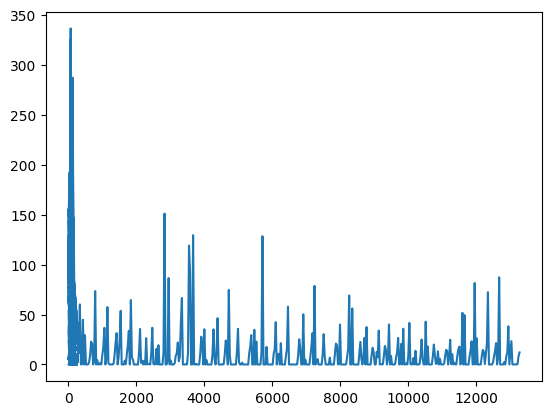

In [ ]:
#plt.plot(df['julianday'], df['mixdepth_mean_m'])
# plt.plot(df['julianday'], df['mixdepth_max_m'] - df['mixdepth_mean_m'])

In [14]:
line_vals

['37.00',
 '13305.00',
 '293.93',
 '64.20',
 '3.46',
 '184.08',
 '386.94',
 '87938.20',
 '9.98',
 '-50.90',
 '-8.43',
 '20.57',
 '-50.90',
 '-8.43']